# Homework 4: Structure From Motion with Bundle Adjustment

In [1]:
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from hw3_defs import get_all_matches

import os
from os import path as os_path
file_path = os_path.dirname(os_path.realpath(''))
img_dir = file_path + "/HW4/buddha_images"

Define Camera Intrinsics (K) based on IPhone Specs given in class.<br>
Important Note: Images 2 and 3 were ignored.

In [2]:
# Camera intrinsics
K = np.array([[1600.0, 0.0, 960.0],
              [0.0, 1600.0, 540.0],
              [0.0,0.0,1.0]])

image_list = []
for image in sorted(os.listdir(img_dir)):
    if image[-4:].lower() == '.jpg' or image[-4:].lower() == '.png':
        image_list.append(img_dir + '/' + image)

imgs = []
for file_path1 in image_list: 
    imgs.append(cv2.imread(file_path1))

In [3]:
from scipy.optimize import least_squares

def optimal_reprojection_error(obj_points) -> np.array:
    '''
    calculates of the reprojection error during bundle adjustment
    returns error 
    '''
    transform_matrix = obj_points[0:12].reshape((3,4))
    K = obj_points[12:21].reshape((3,3))
    rest = int(len(obj_points[21:]) * 0.4)
    p = obj_points[21:21 + rest].reshape((2, int(rest/2))).T
    obj_points = obj_points[21 + rest:].reshape((int(len(obj_points[21 + rest:])/3), 3))
    rot_matrix = transform_matrix[:3, :3]
    tran_vector = transform_matrix[:3, 3]
    rot_vector, _ = cv2.Rodrigues(rot_matrix)
    image_points, _ = cv2.projectPoints(obj_points, rot_vector, tran_vector, K, None)
    image_points = image_points[:, 0, :]
    error = [ (p[idx] - image_points[idx])**2 for idx in range(len(p))]
    return np.array(error).ravel()/len(p)

def bundle_adjustment(_3d_point, opt, transform_matrix_new, K, r_error=0.5) -> tuple:
    '''
    Bundle adjustment for the image and object points
    returns object points, image points, transformation matrix
    '''
    opt_variables = np.hstack((transform_matrix_new.ravel(), K.ravel()))
    opt_variables = np.hstack((opt_variables, opt.ravel()))
    opt_variables = np.hstack((opt_variables, _3d_point.ravel()))

    values_corrected = least_squares(optimal_reprojection_error, opt_variables, gtol = r_error).x
    K = values_corrected[12:21].reshape((3,3))
    rest = int(len(values_corrected[21:]) * 0.4)
    return values_corrected[21 + rest:].reshape((int(len(values_corrected[21 + rest:])/3), 3)), values_corrected[21:21 + rest].reshape((2, int(rest/2))).T, values_corrected[0:12].reshape((3,4))

In [4]:
enable_bundle_adjustment = True

# Find Feature Matches

In [5]:
feature_matches = get_all_matches(imgs, print_matches=False)

In [6]:
transform_matrix_0 = np.eye(4)[:3,:]

pose_0 = np.matmul(K, transform_matrix_0)
pose_1 = np.empty((3, 4)) 
total_points = np.zeros((1, 3))
total_colors = np.zeros((1, 3))

feature_0, feature_1 = feature_matches[0]

# Find Essential Matrix

In [7]:
def get_essential_matrix(points1, points2):
    # Essential matrix
    essential_matrix, em_mask = cv2.findEssentialMat(points1, points2, K, method=cv2.RANSAC, prob=0.999, threshold=0.4, mask=None)
    # Only keep inlier points
    points1 = points1[em_mask.ravel() == 1]
    points2 = points2[em_mask.ravel() == 1]

    return essential_matrix, em_mask, (points1, points2)

In [8]:
essential_matrix, em_mask, (feature_0, feature_1) = get_essential_matrix(feature_0, feature_1)

# Recover Pose
Recover Pose from the essential matrix using cv2.recoverPose.<br>
This method returns triangulated 3D points that pass the cheirality check

In [9]:
def get_pose(essential_matrix, em_mask, pts1, pts2):
    _, rot_matrix, tran_matrix, em_mask = cv2.recoverPose(essential_matrix, pts1, pts2, K)

    transformation_matrix = np.hstack((rot_matrix, tran_matrix))

    # Apply Cheirality check to points
    f_pts1 = pts1[em_mask.ravel() > 0]
    f_pts2 = pts2[em_mask.ravel() > 0]

    return transformation_matrix, f_pts1, f_pts2

In [10]:
transformation_matrix_1, feature_0, feature_1 = get_pose(essential_matrix, em_mask, feature_0, feature_1)

In [11]:
# transformation_matrices1 = []
# transformation_matrices1.append(np.vstack((transformation_matrix_1,[0,0,0,1])))

# for i in tqdm(range(len(image_list)-2)):
#     # Find and Match Features
#     features_cur, features_2 = feature_matches[i+1]

#     essential_matrix, em_mask, (feature_01, feature_11) = get_essential_matrix(features_cur, features_2)
#     transformation_matrix_11, feature_01, feature_11 = get_pose(essential_matrix, em_mask, feature_01, feature_11)
#     transformation_matrices1.append(np.vstack((transformation_matrix_11,[0,0,0,1])).dot(transformation_matrices1[i-1]))

In [12]:
# fig = plt.figure(figsize = (12,12))
# ax = fig.add_subplot(projection='3d')
# # gtsam.utils.plot.plot_3d_points(1, result)
# print(transformation_matrices1)
# points = []
# for t in transformation_matrices1:
#     points.append(t[:3, 3])
#     print(points)

# xPts = [pt_cloud[0] for pt_cloud in points]
# yPts = [pt_cloud[1] for pt_cloud in points]
# zPts = [pt_cloud[2] for pt_cloud in points]

# ax.scatter(xPts, yPts, zPts, s=3)

# ax.set_xlim3d(-10, 10)
# ax.set_ylim3d(-10, 10)
# ax.set_zlim3d(-10, 10)

# plt.show()

# Triangulation

In [13]:
def triangulation(point_2d_1, point_2d_2, projection_matrix_1, projection_matrix_2) -> tuple:
    '''
    Triangulates 3d points from 2d vectors and projection matrices
    returns projection matrix of first camera, projection matrix of second camera, point cloud 
    '''
    pt_cloud = cv2.triangulatePoints(point_2d_1, point_2d_2, projection_matrix_1.T, projection_matrix_2.T)
    return projection_matrix_1.T, projection_matrix_2.T, (pt_cloud / pt_cloud[3])    


In [14]:
# Get Projection Matrix from Transformation Matrix
pose_1 = K @ transformation_matrix_1

feature_0_new, feature_1_new, points_3d = triangulation(pose_0, pose_1, feature_0, feature_1)

# Reprojection Error

In [15]:
def reprojection_error(obj_points, image_points, transform_matrix, K, homogenity) ->tuple:
    '''
    Calculates the reprojection error ie the distance between the projected points and the actual points.
    returns total error, object points
    '''
    rot_matrix = transform_matrix[:3, :3]
    tran_vector = transform_matrix[:3, 3]
    rot_vector, _ = cv2.Rodrigues(rot_matrix)
    if homogenity == 1:
        obj_points = cv2.convertPointsFromHomogeneous(obj_points.T)
    image_points_calc, _ = cv2.projectPoints(obj_points, rot_vector, tran_vector, K, None)
    image_points_calc = np.float32(image_points_calc[:, 0, :])
    total_error = cv2.norm(image_points_calc, np.float32(image_points.T) if homogenity == 1 else np.float32(image_points), cv2.NORM_L2)
    return total_error / len(image_points_calc), obj_points

In [16]:
error, points_3d_new = reprojection_error(points_3d, feature_1_new, transformation_matrix_1, K, homogenity = 1)
#ideally error < 1
print("REPROJECTION ERROR: ", error)

REPROJECTION ERROR:  0.00832392009792166


# PnP

We could continue to extract the point cloud and camera poses from the sequence of: <br>
* Compute the Fundamental Matrix between image pairs
* Form the Essential Matrix from the Fundamental Matrix
* Recover the Camera Pose / Transformation Matrix from the extracted features
* Find the relative translation scale (because cv2.recoverPose gives Unit-Vector Translation)
* Triangulate 3D points from the camera poses
* Perform Data Association techniques to correlate 3D points with the contributing 2D features


Or, we can use the PnP RANSAC Algorithm, which can perform these steps iteratively and returns the associated 2D image points and 3D point cloud

In [17]:
def PnP(obj_point, image_point , K, dist_coeff, rot_vector, initial) ->  tuple:
    '''
    Finds an object pose from 3D-2D point correspondences using the RANSAC scheme.
    returns rotational matrix, translational matrix, image points, object points, rotational vector
    '''
    if initial == 1:
        obj_point = obj_point[:, 0 ,:]
        image_point = image_point.T
        rot_vector = rot_vector.T 
    
    _, rot_vector_calc, tran_vector, inlier = cv2.solvePnPRansac(obj_point, image_point, K, dist_coeff, cv2.SOLVEPNP_ITERATIVE)
    # Converts a rotation matrix to a rotation vector or vice versa
    rot_matrix, _ = cv2.Rodrigues(rot_vector_calc)

    if inlier is not None:
        image_point = image_point[inlier[:, 0]]
        obj_point = obj_point[inlier[:, 0]]
        rot_vector = rot_vector[inlier[:, 0]]
    return np.hstack((rot_matrix, tran_vector)), image_point, obj_point

In [18]:
_, feature_1_pnp, points_3d_pnp = PnP(points_3d_new, feature_1_new, K, np.zeros((5, 1), dtype=np.float32), feature_0_new, initial=1)

# Loop for all Images

In [19]:
def common_points(image_points_1, image_points_2, image_points_3) -> tuple:
    '''
    Finds the common points between image 1 and 2 , image 2 and 3
    returns common points of image 1-2, common points of image 2-3, mask of common points 1-2 , mask for common points 2-3 
    '''
    cm_points_1 = []
    cm_points_2 = []
    for i in range(image_points_1.shape[0]):
        a = np.where(image_points_2 == image_points_1[i, :])
        if a[0].size != 0:
            cm_points_1.append(i)
            cm_points_2.append(a[0][0])

    mask_array_1 = np.ma.array(image_points_2, mask=False)
    mask_array_1.mask[cm_points_2] = True
    mask_array_1 = mask_array_1.compressed()
    mask_array_1 = mask_array_1.reshape(int(mask_array_1.shape[0] / 2), 2)

    mask_array_2 = np.ma.array(image_points_3, mask=False)
    mask_array_2.mask[cm_points_2] = True
    mask_array_2 = mask_array_2.compressed()
    mask_array_2 = mask_array_2.reshape(int(mask_array_2.shape[0] / 2), 2)
    print(" Shape New Array", mask_array_1.shape, mask_array_2.shape)
    return np.array(cm_points_1), np.array(cm_points_2), mask_array_1, mask_array_2

In [20]:
feature_0_loop = feature_0_new
feature_1_loop = feature_1_pnp
points_3d_loop = points_3d_pnp

transform_matrix_0 = np.copy(transformation_matrix_1)

transformation_matrices = []
transformation_matrices.append(transform_matrix_0)

for i in tqdm(range(len(image_list)-2)):
    # Find and Match Features
    features_cur, features_2 = feature_matches[i+1]
    
    if i != 0:
        # Perform Triangulation to get 3D points
        feature_0_loop, feature_1_loop, points_3d_loop = triangulation(pose_0, pose_1, feature_0_loop, feature_1_loop)
        feature_1_loop = feature_1_loop.T
        points_3d_loop = cv2.convertPointsFromHomogeneous(points_3d_loop.T)
        points_3d_loop = points_3d_loop[:, 0, :]
    
    # Finds common points between images
    cm_points_0, cm_points_1, cm_mask_0, cm_mask_1 = common_points(feature_1_loop, features_cur, features_2)
    cm_points_2 = features_2[cm_points_1]
    cm_points_cur = features_cur[cm_points_1]

    # Performs PnP
    transform_matrix_1, cm_points_2, points_3d_loop = PnP(points_3d_loop[cm_points_0], cm_points_2, K, np.zeros((5, 1), dtype=np.float32), cm_points_cur, initial = 0)
    pose_2 = K @ transform_matrix_1

    error, points_3d_loop = reprojection_error(points_3d_loop, cm_points_2, transform_matrix_1, K, homogenity = 0)

    
    cm_mask_0, cm_mask_1, points_3d_loop = triangulation(pose_1, pose_2, cm_mask_0, cm_mask_1)
    error, points_3d_loop = reprojection_error(points_3d_loop, cm_mask_1, transform_matrix_1, K, homogenity = 1)
    print("Reprojection Error: ", error)

    # takes a long time to run
    if enable_bundle_adjustment:
        points_3d_loop, cm_mask_1, transform_matrix_1 = bundle_adjustment(points_3d_loop, cm_mask_1, transform_matrix_1, K)
        pose_2 = np.matmul(K, transform_matrix_1)
        error, points_3d_loop = reprojection_error(points_3d_loop, cm_mask_1, transform_matrix_1, K, homogenity = 0)
        print("Bundle Adjusted error: ",error)
        total_points = np.vstack((total_points, points_3d_loop))
        points_left = np.array(cm_mask_1, dtype=np.int32)
        color_vector = np.array([cv2.cvtColor(imgs[i+2], cv2.COLOR_BGR2RGB)[l[1], l[0]] for l in points_left])
        total_colors = np.vstack((total_colors, color_vector))
    else:
        total_points = np.vstack((total_points, points_3d_loop[:, 0, :]))
        points_left = np.array(cm_mask_1, dtype=np.int32)
        color_vector = np.array([cv2.cvtColor(imgs[i+2], cv2.COLOR_BGR2RGB)[l[1], l[0]] for l in points_left.T])
        total_colors = np.vstack((total_colors, color_vector)) 

    transformation_matrices.append(transform_matrix_1)

    transform_matrix_0 = np.copy(transform_matrix_1)
    pose_0 = np.copy(pose_1)
    feature_0_loop = np.copy(features_cur)
    feature_1_loop = np.copy(features_2)
    pose_1 = np.copy(pose_2)

  0%|          | 0/20 [00:00<?, ?it/s]

 Shape New Array (394, 2) (394, 2)
Reprojection Error:  5.5200644797071385
Bundle Adjusted error:  0.016333865217170295


  5%|▌         | 1/20 [00:32<10:08, 32.00s/it]

 Shape New Array (335, 2) (335, 2)
Reprojection Error:  2.4593762960722634
Bundle Adjusted error:  0.005783332809739294


 10%|█         | 2/20 [00:49<07:00, 23.38s/it]

 Shape New Array (475, 2) (475, 2)
Reprojection Error:  3.3402775398429325
Bundle Adjusted error:  0.012195737714291303


 15%|█▌        | 3/20 [01:47<11:05, 39.13s/it]

 Shape New Array (412, 2) (412, 2)
Reprojection Error:  15.321656107354668
Bundle Adjusted error:  0.03752059045282436


 20%|██        | 4/20 [02:57<13:40, 51.29s/it]

 Shape New Array (246, 2) (246, 2)
Reprojection Error:  82.1835526974264
Bundle Adjusted error:  0.013269145408303517


 25%|██▌       | 5/20 [03:20<10:19, 41.28s/it]

 Shape New Array (325, 2) (325, 2)
Reprojection Error:  19.851365483765274
Bundle Adjusted error:  0.0247889034746143


 30%|███       | 6/20 [03:49<08:39, 37.11s/it]

 Shape New Array (287, 2) (287, 2)
Reprojection Error:  5.8412504698641285
Bundle Adjusted error:  0.04082612726214224


 35%|███▌      | 7/20 [04:12<07:00, 32.32s/it]

 Shape New Array (317, 2) (317, 2)
Reprojection Error:  11.485519313415946
Bundle Adjusted error:  0.07312096011410049


 40%|████      | 8/20 [04:39<06:09, 30.80s/it]

 Shape New Array (551, 2) (551, 2)
Reprojection Error:  1.7915606903665628
Bundle Adjusted error:  0.08655147780302364


 45%|████▌     | 9/20 [07:17<12:55, 70.48s/it]

 Shape New Array (219, 2) (219, 2)
Reprojection Error:  6.054541827800131
Bundle Adjusted error:  0.014995872000559423


 50%|█████     | 10/20 [08:24<11:34, 69.49s/it]

 Shape New Array (202, 2) (202, 2)
Reprojection Error:  6.906217346468731
Bundle Adjusted error:  0.01720210200610972


 55%|█████▌    | 11/20 [08:40<07:57, 53.03s/it]

 Shape New Array (551, 2) (551, 2)
Reprojection Error:  23.333111278619707
Bundle Adjusted error:  0.0698485106752387


 60%|██████    | 12/20 [10:56<10:27, 78.38s/it]

 Shape New Array (424, 2) (424, 2)
Reprojection Error:  28.937590506660392
Bundle Adjusted error:  0.5189792988542232


 65%|██████▌   | 13/20 [15:45<16:35, 142.20s/it]

 Shape New Array (422, 2) (422, 2)
Reprojection Error:  3.409692994933309
Bundle Adjusted error:  0.034415407094391774


 70%|███████   | 14/20 [16:13<10:45, 107.59s/it]

 Shape New Array (436, 2) (436, 2)
Reprojection Error:  0.7150181179023358
Bundle Adjusted error:  0.09315174507111217


 75%|███████▌  | 15/20 [16:36<06:50, 82.18s/it] 

 Shape New Array (398, 2) (398, 2)
Reprojection Error:  2.733739357036282
Bundle Adjusted error:  0.13759640276357488


 80%|████████  | 16/20 [17:08<04:28, 67.01s/it]

 Shape New Array (542, 2) (542, 2)
Reprojection Error:  2.4373086217640267
Bundle Adjusted error:  0.04921199694545677


 85%|████████▌ | 17/20 [17:45<02:54, 58.12s/it]

 Shape New Array (506, 2) (506, 2)
Reprojection Error:  7.909346009567874
Bundle Adjusted error:  0.07965488753519603


 90%|█████████ | 18/20 [18:45<01:57, 58.62s/it]

 Shape New Array (353, 2) (353, 2)
Reprojection Error:  21.058327793519823
Bundle Adjusted error:  0.14108608568481257


 95%|█████████▌| 19/20 [19:32<00:55, 55.01s/it]

 Shape New Array (231, 2) (231, 2)
Reprojection Error:  9.831758776697205
Bundle Adjusted error:  0.05102151366666154


100%|██████████| 20/20 [19:48<00:00, 59.42s/it]


In [23]:
# import open3d as o3d

# pcd = o3d.io.read_point_cloud(file_path + '/HW4/res1/myPC1.ply')
# o3d.visualization.draw_geometries([pcd],
#                                   zoom=0.3412,
#                                   front=[0.4257, -0.2125, -0.8795],
#                                   lookat=[2.6172, 2.0475, 1.532],
#                                   up=[-0.0694, -0.9768, 0.2024])

# Start GTSAM

https://github.com/gtbook/gtsam-examples/blob/main/SFMExample.ipynb

This was my main inspiration

https://gtsam-jlblanco-docs.readthedocs.io/en/latest/StructureFromMotion.html

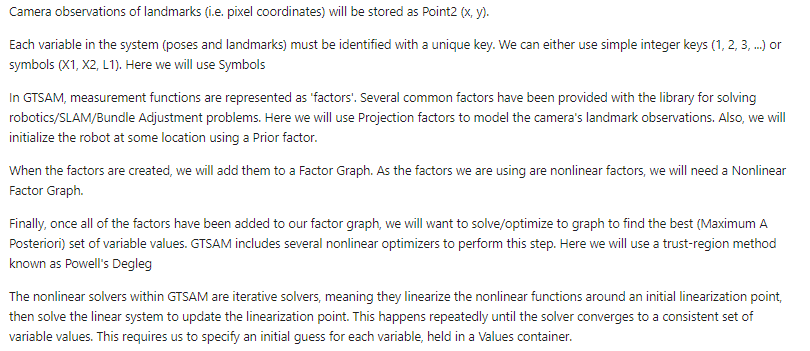

In [36]:
import gtsam
from gtsam import symbol_shorthand

from gtsam import (Cal3_S2, DoglegOptimizer,
                         GenericProjectionFactorCal3_S2, Marginals,
                         NonlinearFactorGraph, PinholeCameraCal3_S2, Point3,
                         Pose3, PriorFactorPoint3, PriorFactorPose3, Rot3, Values)
from gtsam.utils import plot
from gtsam.examples import SFMdata

L = symbol_shorthand.L # L is the integer key for landmarks
X = symbol_shorthand.X # X is the integer key for poses

# Define the camera calibration parameters
gtsam_camera_matrix = gtsam.Cal3_S2(
    K[0, 0], K[1, 1], 0.0, K[0, 2], K[1, 2])

# Define the camera observation noise model
measurement_noise = gtsam.noiseModel.Isotropic.Sigma(2, 1.0)  # one pixel in u and v

In [37]:
# Save points and poses in GTSAM format
points = []
for pt in total_points:
    points.append(np.array(pt))

poses = []
for t in transformation_matrices:
    poses.append(Pose3(t[:3,:]))

In [38]:
# Create a factor graph
graph = NonlinearFactorGraph()

# Add a prior on pose x1. This indirectly specifies where the origin is.
# 0.3 rad std on roll,pitch,yaw and 0.1m on x,y,z
pose_noise = gtsam.noiseModel.Diagonal.Sigmas(
     np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))
factor = PriorFactorPose3(X(0), poses[0], pose_noise)
graph.push_back(factor)

# Simulated measurements from each camera pose, adding them to the factor graph
for i, pose in enumerate(poses):
    camera = PinholeCameraCal3_S2(pose, gtsam_camera_matrix)
    for j, point in enumerate(points):
        try:
            measurement = camera.project(point)
            factor = GenericProjectionFactorCal3_S2(
                measurement, measurement_noise, X(i), L(j), gtsam_camera_matrix)
            graph.push_back(factor)
        except RuntimeError:
            # print("cheirality exception caught!")
            continue
        

In [39]:
point_noise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)
factor = PriorFactorPoint3(L(0), points[0], point_noise)
graph.push_back(factor)
# graph.print('Factor Graph:\n')

In [40]:
# Make Initial Estimates and initialize a random amount off the ground truth!
initial_estimate = Values()
for i, pose in enumerate(poses):
    transformed_pose = pose.retract(0.01*np.random.randn(6, 1))
    initial_estimate.insert(X(i), transformed_pose)
for j, point in enumerate(points):
    transformed_point = point + 0.01*np.random.randn(3)
    initial_estimate.insert(L(j), transformed_point)
# initial_estimate.print('Initial Estimates:\n')

# Optimize Graph and Print Results

In [43]:
# May need to run code above until no error happens...
params = gtsam.DoglegParams()
optimizer = gtsam.DoglegOptimizer(graph, initial_estimate, params)

print('Optimizing:')
result = optimizer.optimize()
# result.print('Final results:\n')
print('initial error = {}'.format(graph.error(initial_estimate)))
print('final error = {}'.format(graph.error(result)))

Optimizing:


RuntimeError: 
Indeterminant linear system detected while working near variable
7782220156096217249 (Symbol: l161).

Thrown when a linear system is ill-posed.  The most common cause for this
error is having underconstrained variables.  Mathematically, the system is
underdetermined.  See the GTSAM Doxygen documentation at
http://borg.cc.gatech.edu/ on gtsam::IndeterminantLinearSystemException for
more information.

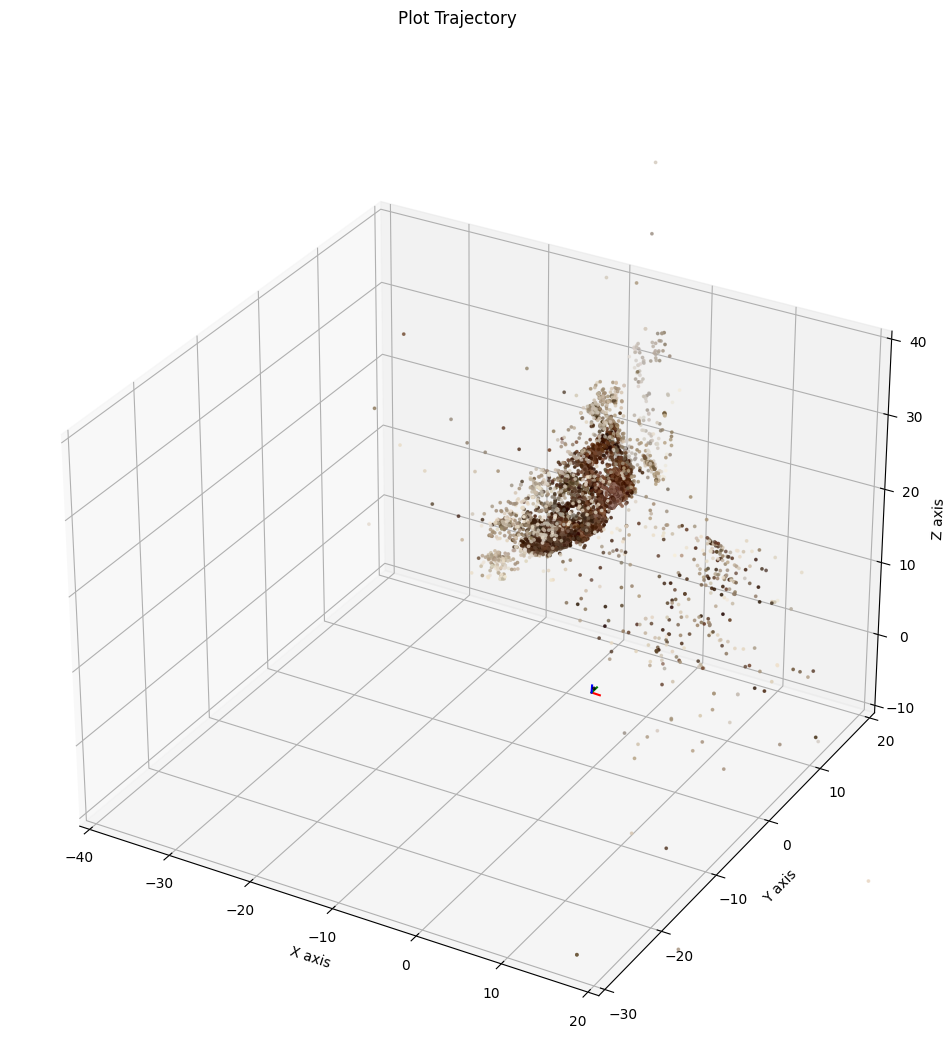

In [ ]:
# %matplotlib ipympl
import matplotlib.pyplot as plt 


fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(projection='3d')
# gtsam.utils.plot.plot_3d_points(1, result)
gtsam.utils.plot.plot_trajectory(1, result, scale=1)
gtsam.utils.plot.set_axes_equal(1)

xPts = [pt_cloud[0] for pt_cloud in points]
yPts = [pt_cloud[1] for pt_cloud in points]
zPts = [pt_cloud[2] for pt_cloud in points]

ax.scatter(xPts, yPts, zPts, s=3, c=total_colors/255)

ax.set_xlim3d(-40, 20)
ax.set_ylim3d(-30, 20)
ax.set_zlim3d(-10, 40)

plt.show()